In [1]:
PYTHON_PATHS = [".."]
import sys
for path in PYTHON_PATHS:
    if path not in sys.path:
        sys.path.append(path)
import pytorch_lightning as pl
import os
from pytorch_lightning.utilities.parsing import AttributeDict
from pytorch_lightning.loggers import TensorBoardLogger
import numpy as np
import matplotlib.pyplot as plt
import torch
import cv2
import albumentations
import torchvision.transforms as transforms
import torchvision

In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [3]:
from sparse_feature_pyramid.model import SparseFeaturePyramidAutoencoder
from sparse_feature_pyramid.data import SevenScenesDataModule
from sparse_feature_pyramid.utils import UniversalFactory

factory = UniversalFactory([SparseFeaturePyramidAutoencoder])

In [4]:
from clearml import Task, Logger

In [5]:
task = Task.init(project_name="sparse-feature-pyramid", task_name="Sparse feature pyramid on local machine")

ClearML Task: created new task id=ca5500997f3546b3bde4bc16ac0e0112
CLEARML new package available: UPGRADE to v1.1.1 is recommended!
Release Notes:
### Bug Fixes

- Fix `Logger.report_image()` throws warning
- Fix TensorBoard `add_image()` not being reported
ClearML results page: https://app.community.clear.ml/projects/d9943ce0df704ec4a0feddd4bf78762f/experiments/ca5500997f3546b3bde4bc16ac0e0112/output/log


# Load datamodule

In [148]:
data_module_parameters = {
    "batch_size": 64,
    "num_workers": 4,
    "image_size": 128,
    "scene": "fire",
    "center_crop": True,
    "random_jitter": True,
    "random_rotation": True,
    "root_dataset_path": "/media/mikhail/Data3T/7scenes"
}
task.connect(data_module_parameters)
scene = data_module_parameters["scene"]
data_module = SevenScenesDataModule(**data_module_parameters)

[ToyDataModule] - train subset size 2000
[ToyDataModule] - validation dataset size 2000


# Model

In [149]:
model_parameters = AttributeDict(
    name="SparseFeaturePyramidAutoencoder",
    optimizer=AttributeDict(),
    feature_dimensions=[8, 16, 32, 64, 128],
    size_loss_koef=1 / 100000.,
    input_dimension=3,
)
task.connect(model_parameters)
model = factory.make_from_parameters(model_parameters)

# Trainer

In [150]:
logger_path = os.path.join(os.path.dirname(task.cache_dir), "lightning_logs", "sparse_feature_pyramid")
trainer_parameters = {
    "max_epochs": 100,
    "checkpoint_every_n_val_epochs": 10,
    "gpus": 1,
    "check_val_every_n_epoch": 2
}
task.connect(trainer_parameters)
model_checkpoint = pl.callbacks.ModelCheckpoint(monitor='val_loss',
    every_n_val_epochs=trainer_parameters["checkpoint_every_n_val_epochs"])
trainer = factory.kwargs_function(pl.Trainer)(
    logger=TensorBoardLogger(logger_path, name=scene),
    callbacks=[model_checkpoint],
    **trainer_parameters
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [151]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type       | Params
----------------------------------------------------
0 | _encoder_blocks      | ModuleList | 294 K 
1 | _decoder_blocks      | ModuleList | 680 K 
2 | _input_convolution   | Sequential | 824   
3 | _output_convolutions | ModuleList | 6.7 K 
4 | _mask_convolutions   | ModuleList | 2.2 K 
5 | _loss                | MSELoss    | 0     
----------------------------------------------------
985 K     Trainable params
0         Non-trainable params
985 K     Total params
3.942     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

# Show results

In [268]:
batch = None
for x in data_module.train_dataloader():
    batch = x
    break

In [269]:
output = model(batch["image"])

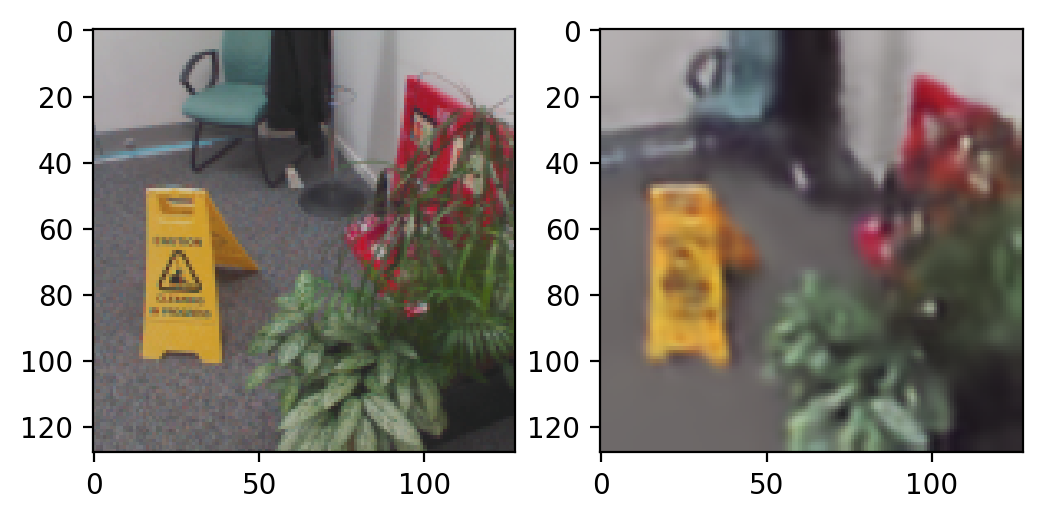

In [270]:
fig, ax = plt.subplots(1, 2, dpi=200)
output_image = output[0][0][0].detach().cpu().numpy().transpose(1, 2, 0)
output_image = output_image * np.array(data_module._std)[None, None] + np.array(data_module._mean)[None, None]
output_image = np.clip(output_image, 0, 1)
ax[1].imshow(output_image)

input_image = torch.nn.functional.interpolate(batch["image"], size=output_image.shape[:2])
input_image = input_image[0].detach().cpu().numpy().transpose(1, 2, 0)
input_imag input_image * np.array(data_module._std)[None, None] + np.array(data_module._mean)[None, None]
input_image = np.clip(input_image, 0, 1)
ax[0].imshow(input_image)

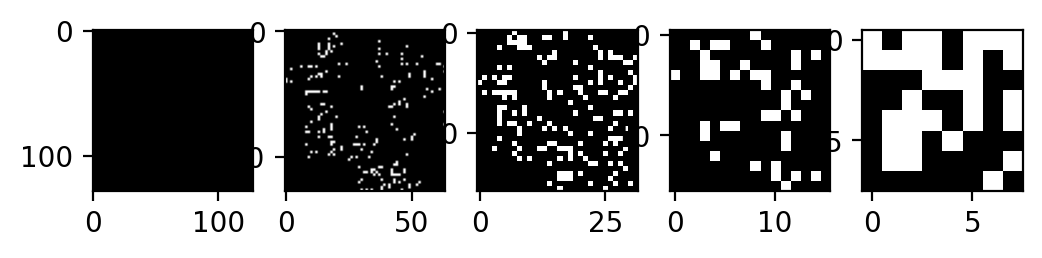

In [271]:
fig, ax = plt.subplots(1, 5, dpi=200)
for i in range(5):
    mask = output[2][i][0][0].detach().cpu().numpy()
    ax[i].imshow(mask, cmap="gray")

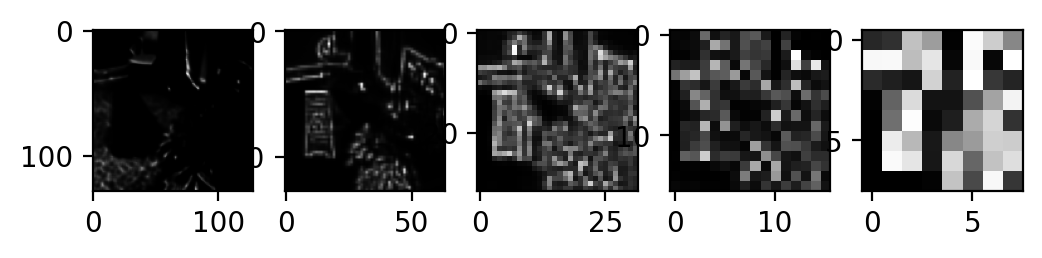

In [272]:
fig, ax = plt.subplots(1, 5, dpi=200)
for i in range(5):
    mask = output[3][i][0][0].detach().cpu().numpy()
    ax[i].imshow(mask, cmap="gray")

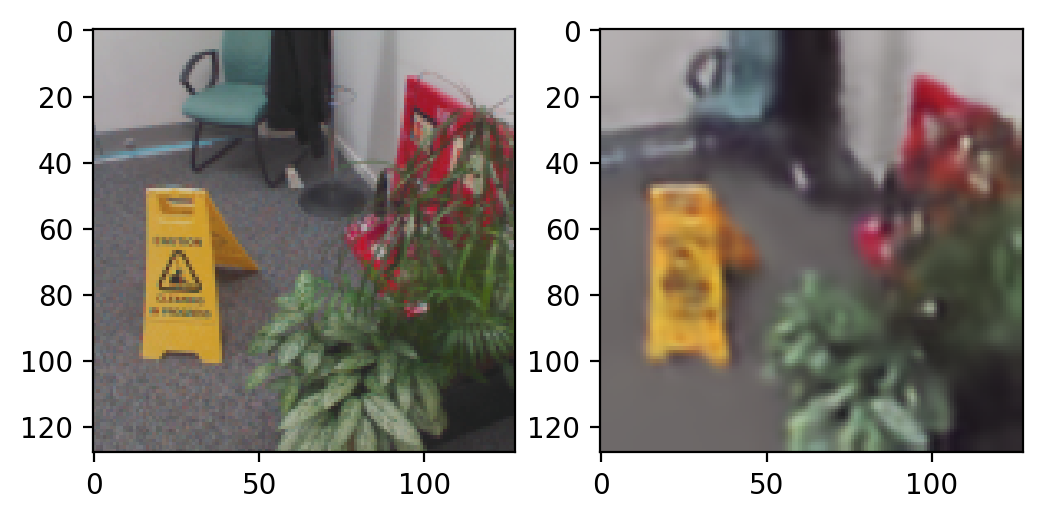

In [315]:
masked_feature_pyramid = [feature * mask for feature, mask in zip(output[1], output[2])]
# masked_feature_pyramid = [feature * torch.where(probability > 0.3, 1., 0.) for 
#                           feature, probability in zip(output[1], output[3])]
# masked_feature_pyramid[4] = torch.zeros_like(masked_feature_pyramid[4])
# masked_feature_pyramid[3] = torch.zeros_like(masked_feature_pyramid[3])
# masked_feature_pyramid[2] = torch.zeros_like(masked_feature_pyramid[2])
# masked_feature_pyramid[1] = torch.zeros_like(masked_feature_pyramid[1])
# masked_feature_pyramid[0] = torch.zeros_like(masked_feature_pyramid[0])

x = masked_feature_pyramid[-1]
for i in range(len(model._decoder_blocks)):
    x = model._decoder_blocks[i](x, masked_feature_pyramid[-i - 2])

output_image = model._output_convolutions[0](x)
fig, ax = plt.subplots(1, 2, dpi=200)
output_image = output_image[0].detach().cpu().numpy().transpose(1, 2, 0)
output_image = output_image * np.array(data_module._std)[None, None] + np.array(data_module._mean)[None, None]
output_image = np.clip(output_image, 0, 1)
ax[1].imshow(output_image)

input_image = torch.nn.functional.interpolate(batch["image"], size=output_image.shape[:2])
input_image = input_image[0].detach().cpu().numpy().transpose(1, 2, 0)
input_image = input_image * np.array(data_module._std)[None, None] + np.array(data_module._mean)[None, None]
# input_image = np.clip(input_image, 0, 1)
ax[0].imshow(input_image)

In [307]:
task.logger.report_matplotlib_figure("reconstructed", "all", fig, iteration=3, report_image=True)

In [292]:
sum([torch.sum(x[0]) for x in output[3]])

tensor(443.6386, grad_fn=<AddBackward0>)

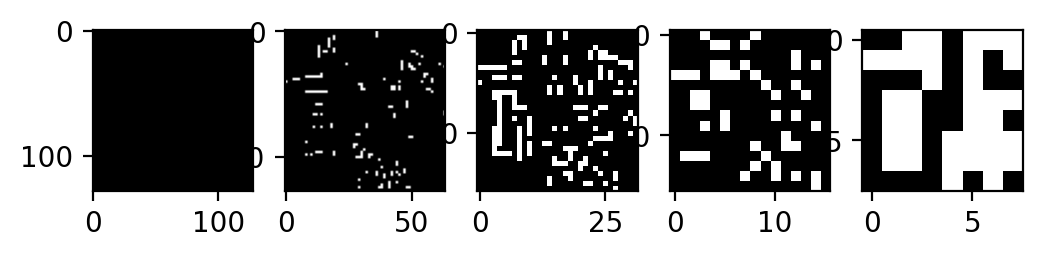

In [293]:
# mask = [torch.where(probability > 0.5, 1., 0.) for probability in output[3]]
fig, ax = plt.subplots(1, 5, dpi=200)
for i in range(5):
    mask = torch.where(output[3][i] > 0.3, 1., 0.)[0][0].detach().cpu().numpy()
    ax[i].imshow(mask, cmap="gray")

In [78]:
np.sum(output[3][4][0][0].detach().cpu().numpy())

40.741444

In [17]:
np.max(output[3][0][0][0].detach().cpu().numpy())

0.10532381

In [18]:
prob

NameError: name 'prob' is not defined

In [ ]:
prob = output[3][0][0][0]
prob * torch.log(prob) + (1 - prob) * torch.log(1 - prob)

In [ ]:
output[4][4][0][0]

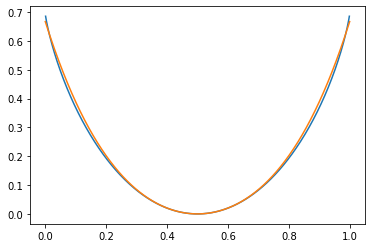

In [137]:
x = np.linspace(0, 1, 1000)
y = x * np.log(x) + (1 - x) * np.log(1 - x) + np.log(2)
z = 2 * (x - 0.5) ** 2 + 8 / 3 * (x - 0.5) ** 4
plt.plot(x, y)
plt.plot(x, z)

In [ ]:
output[4][0][0][0]

In [ ]:
mask = output[3][0][0][0].detach().cpu().numpy()
masked_input_image = input_image * mask[:, :, None]
masked_input_image = (masked_input_image + 1) ** 10 - 1
# masked_input_image = np.clip(masked_input_image, 0, 1) + input_image * 0.5
plt.imshow(masked_input_image)

In [ ]:
task.close()